In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

In [2]:
r1 = 0.1
r2 = 0.2
def r_1(x):
    return r1*x
def r_2(x):
    return r2*x
def int_r_1(x):
    """
        integral of r_1
    """
    return r1/2*x**2
def int_r_2(x):
    """
        integral of r_2
    """
    return r2/2*x**2

#### Modelisation of $A_t^i=\sum_{n=1}^{N_t^i}U_n^i$

In [60]:
# N_t^i is a Possion process with parameter lambda_i
lambda_1 = 1
lambda_2 = 2

class combination_exponential():
    """
        Combination of two exponential random variables which models the strong and weak rainfalls, the distribution is given by:
        nu(u) = b*delta_1*exp(-delta_1*u)1_{u>0} + (1-b)*delta_2*exp(-delta_2*u)1_{u>0}
    """
    def __init__(self, b, delta_1, delta_2):
        assert b > 0 and b < 1
        assert delta_1 > 0
        assert delta_2 > 0
        self.b = b
        self.delta_1 = delta_1
        self.delta_2 = delta_2

    def pdf(self, u):
        """
            Probability density function of the combination of two exponential random variables
        """
        assert u >= 0
        return self.b*self.delta_1*np.exp(-self.delta_1*u) + (1-self.b)*self.delta_2*np.exp(-self.delta_2*u)

    def cdf(self, u):
        """
            Cumulative distribution function of the combination of two exponential random variables
        """
        assert u >= 0
        return self.b*(1-np.exp(-self.delta_1*u)) + (1-self.b)*(1-np.exp(-self.delta_2*u))
    
    def rvs(self, size):
        """
            Random variates of the combination of two exponential random variables
        """
        X = np.random.rand(size)
        return np.random.exponential(1/self.delta_1, size=size) * self.b + np.random.exponential(1/self.delta_2, size=size) * (1-self.b)
        #return np.random.exponential(1/self.delta_1, size=size) * (X < self.b) + np.random.exponential(1/self.delta_2, size=size) * (X >= self.b)

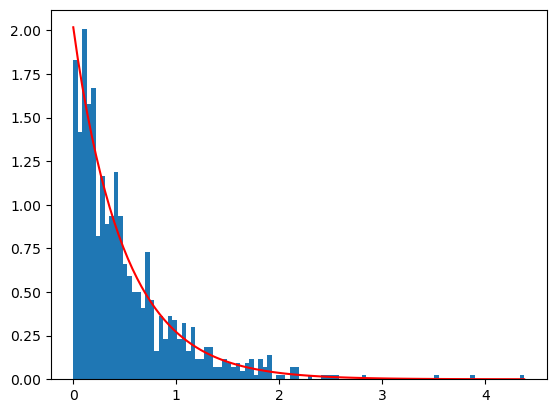

In [71]:
ce = combination_exponential(0.999, 2, 20)
X = ce.rvs(1000)

# évalu

plt.hist(X, bins=100, density=True)
plt.plot(np.linspace(0, np.max(X), 100), [ce.pdf(x) for x in np.linspace(0, np.max(X), 100)], 'r')
plt.show()

In [160]:
from typing import List
class Rainfall():
    """
        Rainfall model
    """
    def __init__(self, lam, b, delta_1, delta_2, r):
        self.lam = lam
        self.b = b
        self.delta_1 = delta_1
        self.delta_2 = delta_2
        self.r = r
        self.ce = combination_exponential(b, delta_1, delta_2)
        # list which represents the Possion process N_t
        self.t : List = []
        # list which represents the quantities of rainfalls at the times t_i
        self.U_t : List = []
    def simulate_for_fiexed_T(self, T):
        """
            Simulate the rainfalls on [0, T]
        """
        N_t = sps.poisson.rvs(self.lam*T)
        self.t = np.concatenate(([0], np.sort(np.random.uniform(0, T, N_t))))
        self.U_t = np.concatenate(([0], self.ce.rvs(N_t)))

    def reset(self):
        """
            Reset the model
        """
        self.t = []
        self.U_t = []
    
    def get_volume(self, x0):
        """
            Get the volume of the barrage on [0, T]
            '''math
                X_t = x0 + A_t - int_0^t r*X_s ds
            '''
        """
        X = [x0]
        for i in range(1, len(self.t)):
            X.append(np.exp(-self.r*(self.t[i]-self.t[i-1]))*X[-1]+self.U_t[i])
        return X
    
    def get_volume_at_t(self, X, t):
        """
            Get the volume of the barrage at time t
        """
        if t > self.t[-1]:
            return np.exp(-self.r*(t-self.t[-1]))*X[-1]
        
        # get i such that t_i <= t < t_{i+1}
        i = 0
        while self.t[i] <= t and i < len(self.t)-1:
            i += 1
        return np.exp(-self.r*(t-self.t[i-1]))*X[i-1]



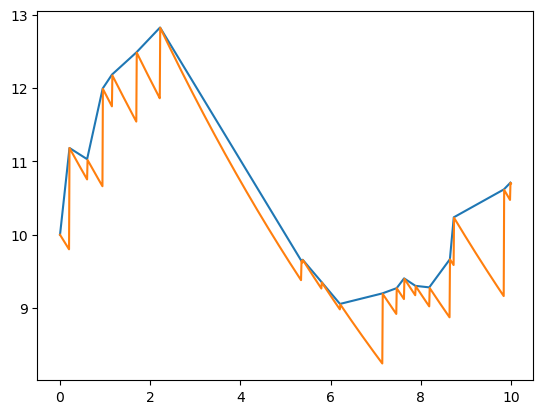

In [167]:
R = Rainfall(1, 0.999, 2, 20, 0.1)
R.simulate_for_fiexed_T(10)
X = R.get_volume(10)
x = np.linspace(0, 10, 1000)
y = [R.get_volume_at_t(X, 10, t) for t in x]
plt.plot(R.t, X)
plt.plot(x, y)
plt.show()